In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
# ==========================
# CONFIG
# ==========================
ROOT_PATH = r"D:\Projects\ML_Bootcamp_Competition_2023_for_Ukrainians\ukraine-ml-bootcamp-2023"
IMAGE_PATH = os.path.join(ROOT_PATH, "images")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_CLASSES = 6
EPOCHS = 1  # Set higher after testing
IMG_SIZE = 128  # Smaller for faster training

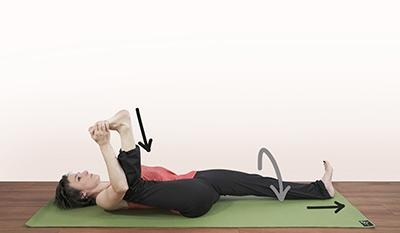

In [7]:
# load images
from PIL import Image
import os

test_path = r"D:\Projects\ML_Bootcamp_Competition_2023_for_Ukrainians\ukraine-ml-bootcamp-2023\images"

def load_image(image_id, folder="test_images"):
    path = os.path.join(test_path, folder, image_id)
    return Image.open(path)

IMAGE_ID = '00d0f4ee536e780443bdf452ec614750.jpg'
load_image(IMAGE_ID)

In [8]:
# ==========================
# LOAD DATA
# ==========================
train_df = pd.read_csv(os.path.join(ROOT_PATH, "train.csv"))
test_image_ids = os.listdir(os.path.join(IMAGE_PATH, "test_images"))
test_df = pd.DataFrame({'image_id': test_image_ids})

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["class_6"], random_state=42)

In [9]:
# ==========================
# TRANSFORMS
# ==========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = train_transform

In [10]:
# ==========================
# DATASET CLASS
# ==========================
class YogaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, folder="train_images", has_labels=True):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.folder = folder
        self.has_labels = has_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image_id"]
        img_path = os.path.join(self.root_dir, self.folder, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = self.df.iloc[idx]["class_6"]
            return image, label
        else:
            return image

In [11]:
# ==========================
# DATA LOADERS
# ==========================
train_dataset = YogaDataset(df=train_df, root_dir=IMAGE_PATH, transform=train_transform, folder="train_images", has_labels=True)
val_dataset = YogaDataset(df=val_df, root_dir=IMAGE_PATH, transform=val_transform, folder="train_images", has_labels=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [12]:
# ==========================
# MODEL (Simplified CNN)
# ==========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # [B, 16, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),                # [B, 16, 64, 64]
            nn.Conv2d(16, 32, 3, padding=1),# [B, 32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),                # [B, 32, 32, 32]
            nn.Conv2d(32, 64, 3, padding=1),# [B, 64, 32, 32]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),   # [B, 64, 1, 1]
            nn.Flatten(),
            nn.Linear(64, NUM_CLASSES)      # [B, NUM_CLASSES]
        )

    def forward(self, x):
        return self.net(x)

model = SimpleCNN().to(DEVICE)

In [13]:
# ==========================
# CLASS WEIGHTS
# ==========================
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class_6']), y=train_df['class_6'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

In [14]:
# ==========================
# LOSS, OPTIMIZER
# ==========================
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return acc


In [16]:
# ==========================
# TRAINING LOOP
# ==========================
def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(loader)
    print(f"[Epoch {epoch}] Train loss: {avg_loss:.4f} | Train accuracy: {acc:.2f}%")

In [ ]:
# ==========================
# TRAIN & VALIDATE
# ==========================
print(f"Device: {DEVICE} | Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    val_acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Validation Accuracy: {val_acc:.2f}%")


Device: cpu | Training samples: 1888 | Validation samples: 472
